<a href="https://colab.research.google.com/github/hoangdungnguyen/XVA-stage/blob/master/Quantile_regression_NNtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import time
import sys, gc
import seaborn as sns
import random
from itertools import chain
from tqdm.notebook import tqdm
import math
import scipy as si
from scipy.stats import norm
import pandas as pd
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from sklearn.preprocessing import PolynomialFeatures


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import torch 
from torch import matmul
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.distributions as tdist
print('GPU available: ',torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


GPU available:  True


# 0 Some tool functions

In [0]:
def KMeans(x, K=10, Niter=20, verbose=False):
    x = x.to(device)
    N, D = x.shape  # Number of samples, dimension of the ambient space

    # K-means loop:
    # - x  is the point cloud,
    # - cl is the vector of class labels
    # - c  is the cloud of cluster centroids
    start = time.time()
    c = x[np.random.permutation(N)[:K], :].clone()  # Simplistic random initialization
    x_i = x[:, None, :]  # (Npoints, 1, D)

    for i in range(Niter):

        c_j = c[None, :, :]  # (1, Nclusters, D)
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (Npoints, Nclusters) symbolic matrix of squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        Ncl = torch.bincount(cl).type(torch.float)  # Class weights
        for d in range(D):  # Compute the cluster centroids with torch.bincount:
            c[:, d] = torch.bincount(cl, weights=x[:, d]) / Ncl

    end = time.time()

    if verbose:
        print("K-means example with {:,} points in dimension {:,}, K = {:,}:".format(N, D, K))
        print('Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n'.format(
                Niter, end - start, Niter, (end-start) / Niter))

    return cl, c

# 1 Data simulator

In [0]:
class call_pricing_generator:

    def __init__(self, dim_X = 5, T = 1.5, r = 0.025, random_state = None) :
        self.dim_X = dim_X
        self.K = np.random.RandomState(random_state).uniform(80, 120, dim_X)
        self.T = T
        self.r = r
        self.sigma = np.random.RandomState(random_state).uniform(0.1,0.5, dim_X)
        self.omega = np.random.RandomState(random_state).uniform(0.,1., dim_X)
  
    def print_para(self):
        return {'dim_X': self.dim_X, 'K': self.K, 'T': self.T, 'r': self.r, 
                'sigma': self.sigma, 'omega': self.omega}

    def simulate(self, N_sim = 10000, random_state = None):
        payoff = np.zeros([N_sim, self.dim_X])
        price = np.zeros([N_sim, self.dim_X])
        S0 = np.zeros([N_sim, self.dim_X])
        for i in range(self.dim_X):
            S0[:,i] = np.random.RandomState(random_state).uniform(10+i*5, 180+i*5, N_sim)
            ST = S0[:,i]*np.exp((self.r-0.5*self.sigma[i]**2)*self.T+self.sigma[i]*np.sqrt(self.T)*np.random.normal(size=N_sim))
            payoff[:,i] = np.exp(-self.r*self.T)*np.maximum(ST-self.K[i], 0)
            d1 = (np.log(S0[:,i]/self.K[i])+(self.r+0.5*self.sigma[i]**2)*self.T)/(self.sigma[i]*np.sqrt(self.T))
            d2 = d1 - self.sigma[i]*np.sqrt(self.T)
            price[:,i] = S0[:,i]*norm.cdf(d1)-np.exp(-self.r*self.T)*self.K[i]*norm.cdf(d2)
            
        payoff = np.sum(payoff*self.omega, axis = 1)
        price = np.sum(price*self.omega, axis = 1)
        return (torch.from_numpy(S0.reshape(-1,self.dim_X)).type(torch.FloatTensor),
                torch.from_numpy(payoff.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(price.reshape(-1,1)).type(torch.FloatTensor))

In [0]:
class var_es_generator:

    def __init__(self, X_dim = 20, eps = 0.025, lambda_rs = 10, mu_rs = 20):
        self.X_dim = X_dim
        self.eps = eps
        self.lambda_rs = lambda_rs
        self.mu_rs = mu_rs
        
    
    def mean_X(self):
        return np.zeros(self.X_dim)
    
    def var_X(self):
        return np.identity(self.X_dim)

    def cond_mean_std_Y(self, X, weight_vector): 
        poly = PolynomialFeatures(2)
        return np.sum(poly.fit_transform(X) * weight_vector, axis = 1)
    
    def simulate(self, nb_simulation = 10000, lambda_0 = 10., mu_0 = 3.) :
        X = np.random.multivariate_normal(self.mean_X(), self.var_X(), nb_simulation)
        #lambda vector : P1(x) = lambda_0 + sum lambda_i*xi + sum lambda_ij*xi*xj
        self.lambda_vector = np.append(lambda_0, np.random.RandomState(self.lambda_rs).normal(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        #mu vector : P2(x) = mu_0 + sum mu_i*xi + sum mu_ij*xi*xj
        self.mu_vector = np.append(mu_0, np.random.RandomState(self.mu_rs).normal(0,1, int(self.X_dim + self.X_dim*(self.X_dim+1)/2) ))

        mean_Y = self.cond_mean_std_Y(X, self.lambda_vector)
        std_Y = self.cond_mean_std_Y(X, self.mu_vector)
        std_Y = np.sqrt(std_Y**2)
        
        Y = np.random.normal(mean_Y, std_Y)

        true_VaR = mean_Y - std_Y*norm.ppf(self.eps)
        true_ES = mean_Y + 1/self.eps * std_Y * norm.pdf(norm.ppf(self.eps)) 

        return (torch.from_numpy(X.reshape(nb_simulation, self.X_dim)).type(torch.FloatTensor), 
                torch.from_numpy(Y.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_VaR.reshape(-1,1)).type(torch.FloatTensor), 
                torch.from_numpy(true_ES.reshape(-1,1)).type(torch.FloatTensor),
                mean_Y,
                std_Y)

In [0]:
test = var_es_generator(X_dim = 5)
X_train, Y_train, true_VaR, true_ES, mean_Y,_ = test.simulate(10000, lambda_0= 20, mu_0 = 10)

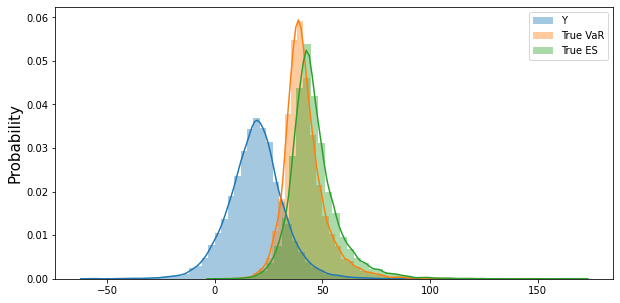

In [7]:
plt.figure(figsize=(10,5))
sns.distplot(Y_train.data, label='Y')
sns.distplot(true_VaR.data, label='True VaR')
sns.distplot(true_ES.data, label='True ES')
plt.title("", fontsize=12)
plt.xlabel("")
plt.ylabel("Probability", fontsize=15)
plt.legend()

#2 Randomized layers

In [0]:
class Randomprojection:

    def __init__(self, Layers = [10, 100], random_state = None, activation = 'sigmoid'):

        self.W, self.b =[], []
        if random_state == None:
            for input_size, output_size in zip(Layers, Layers[1:]):
                self.W.append(tdist.normal.Normal(0., 1.).sample((input_size, output_size)))
                self.b.append(tdist.normal.Normal(0., 1.).sample((output_size,)))
        else:
            for i,input_size, output_size in zip(range(len(Layers)-1),Layers, Layers[1:]):
                torch.manual_seed(random_state+i)
                self.W.append(tdist.normal.Normal(0., 1.).sample((input_size, output_size)))
                torch.manual_seed(2*random_state+i)
                self.W.append(tdist.normal.Normal(0., 1.).sample((output_size,)))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = torch.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def fit_transform(self, X):
        X = X.to(device)
        for W,b in zip(self.W, self.b):
            X = self.activation(torch.matmul(X, W.to(device)) + b.to(device))
        return X

In [0]:
class Autoencoder(nn.Module):

    def __init__(self, Layers = [1,20,40], activation = 'relu'):
        super(Autoencoder, self).__init__()
        self.hidden = nn.ModuleList()
        # Example: Encoder 1 - 20 - 40 and Decoder 40 - 20 - 1
        Layers = Layers + Layers[::-1]
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = F.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

    def forward_central_layer(self, x):
        x = x.to(device)
        L = int(len(self.hidden) / 2)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [0]:
class RBFlayer:
    """RBFlayer.
    Parameters
    ----------
    function: 
        'Gaussian', 'Multiquadric', 'Inverse quadratic' or 'Thin plate spline'.
    """

    def __init__(self, output_layer = 100, e = 1/2, function = 'gaussian'):
        self.K = output_layer
        if function.capitalize() == 'Gaussian' :
            self.activation = lambda x: torch.exp(-e*x)
        elif function.capitalize() == 'Multiquadric':
            self.activation = lambda x: torch.sqrt(1+e*x)
        elif function.capitalize() == 'Inverse quadratic':
            self.activation = lambda x: 1/(1+e*x)
        elif function.capitalize() == 'Thin plate spline':
            self.activation = lambda x: (x**2*torch.log(torch.clamp(x, min=1e-40) )).type(torch.DoubleTensor)


    def fit(self, X):
        _, self.centroids = KMeans(X, self.K, 10)
          
    def transform(self, X):
        self.centroids = self.centroids.to(device)
        dist= torch.empty((X.shape[0],self.K), dtype= torch.float)
        for j in range(self.K):
            dist[:,j] = torch.norm(X - self.centroids[j], dim = 1)
        return self.activation(dist**2)


#3 Readout layers

In [0]:
from sklearn.linear_model import LinearRegression

class LR_readout:
    
    def __init__(self, intercept = True, normalize=False):
        self.lin_reg = LinearRegression(fit_intercept=intercept, normalize=normalize, n_jobs=-1)

    def fit(self, X, y):
        self.lin_reg.fit(X.cpu(),y.cpu())
        self.coef = torch.tensor(self.lin_reg.coef_.T)
    def predict(self, X) :
        
        return torch.from_numpy(self.lin_reg.predict(X.cpu())).type(torch.FloatTensor).to(device)

    def l2_loss(self,X, y):
        y = y.to(device)
        return torch.mean((self.predict(X) - y)**2)

In [0]:
class NN_nlayers(nn.Module):

    def __init__(self, Layers, activation = 'relu'):
        super(NN_nlayers, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))

        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = F.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def forward(self, x):
        x = x.to(device)
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = self.activation(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [0]:
def train_quad_loss(model, X_train, y_train, eps = 1e-8, epochs=300, verbose = None):

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    i = 0
    err = np.inf
    while (err >= eps) and (i < epochs):
        optimizer.zero_grad()
        pred = model.forward(X_train)
        loss = torch.mean((pred - y_train)**2)
        loss.backward()
        optimizer.step()
        err = loss.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1

## Optimal gradient descent learning rate for a quadratic loss function

Considering a quadratic loss for an input matrix ${X}$ (can include a one column vector relating the biais) and an output vector $y$
$$\mathcal{L}(A,b) = \mathbb{E} \left[ || {X}\underbrace{A}_{weight} + \underbrace{b}_{bias} - y ||_2^2  \right] \simeq \frac{1}{n} \left( {X}A + b - y \right)^T \left( {X}A + b - y \right)$$

The goal is to minimize the loss $\mathcal{L}$. Since 1/n is a constant, we can omit it:

$$\mathcal{L}(A,b) = A^T(X^TX)A + b^Tb + y^Ty + 2b^TXA - 2y^TXA - 2y^Tb$$

Suppose a positive real learning rate $\lambda$. The gradient descent with constant $\lambda$ is an iterative algorithm that aims to find a local minimum for $\mathcal{L}$. The updates:
$$A^{k+1} = A^{k} - \lambda \underbrace{\partial_A \mathcal{L}(A^{k}, b^{k})}_{\partial_A\mathcal{L}^{k}}$$
$$b^{k+1} = b^{k} - \lambda \underbrace{\partial_b \mathcal{L}(A^{k}, b^{k}}_{\partial_b\mathcal{L}^{k}})$$

In the case of stochastic learning rate, we rewrite the updates at step $k$ with $\lambda^k$ . The optimal learning rate could be:
$$\lambda^{k} = \arg \min \mathcal{L}(A^{k+1},b^{k+1})$$

Finally, we have:

$$\lambda^k = \frac{\left[X\partial_A\mathcal{L}^k+ \partial_b\mathcal{L}^k \right]^T\left[XA^k+b^k-y\right]}{[X\partial_A \mathcal{L}^k + \partial_b \mathcal{L}^k]^T[X\partial_A \mathcal{L}^k + \partial_b \mathcal{L}^k]}$$

In [0]:
def train_quad_loss_optimal(model, X_train, y_train, eps = 1e-8, epochs=5, verbose = None):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    A,b = model.parameters()
    i = 0
    err, best_err = np.inf, np.inf
    while (err >= eps) and (i < epochs):
        optimizer.zero_grad()
        pred = model.forward(X_train)
        loss = torch.mean((pred - y_train)**2)
        err = loss.data.item()
        if err < best_err:
            best_err = err
            torch.save(model.state_dict(), 'best')
        loss.backward()
        coef = torch.matmul(X_train, A.grad.T)+ b.grad
        lr = torch.matmul(coef.T, torch.matmul(X_train, A.data.T)+ b.data - y_train)/ torch.matmul(coef.T,coef)
        for param_group in optimizer.param_groups:
            param_group['lr'] = float(lr)
        
        
        optimizer.step()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {} | learning rate = {}'.format(i, round(err, 3), round(float(lr),4)))
        i += 1
    model.load_state_dict(torch.load('best'))
    model.eval()
    

# 5 Conditional $\mathbb{VaR}$ & $\mathbb{ES}$ problem

In [15]:
gc.collect()

679

In [0]:
sys_variables = sys.modules[__name__]

def data_simulator(dim_X = 50, eps = 0.025, nb_path = 50000):
    Var_Es_Generator = var_es_generator(X_dim=dim_X, eps = eps, lambda_rs = random.randint(0,2000), mu_rs= random.randint(0,2000))

    X_train, Y_train, true_VaR_train, true_ES_train, mean_Y_train, std_Y_train = Var_Es_Generator.simulate(nb_path, lambda_0 = 10., mu_0 = 3.)
    X_test, Y_test, true_VaR_test, true_ES_test, mean_Y_test, std_Y_test = Var_Es_Generator.simulate(nb_path, lambda_0 = 10., mu_0 = 3.)

    sys_variables.X_train = X_train.to(device)
    sys_variables.Y_train = Y_train.to(device)
    sys_variables.true_VaR_train = true_VaR_train.to(device)
    sys_variables.true_ES_train = true_ES_train.to(device)

    sys_variables.X_test = X_test.to(device)
    sys_variables.Y_test = Y_test.to(device)
    sys_variables.true_VaR_test = true_VaR_test.to(device)
    sys_variables.true_ES_test = true_ES_test.to(device)

    sys_variables.eps = eps
    sys_variables.dim_X = dim_X

In [0]:
data_simulator(dim_X = 50, eps = 0.025)

In [0]:
def NRMSE(pred, true):
    return torch.sqrt(torch.mean((pred - true)**2))/ torch.std(true)

def plot_function(var_train_pre, var_train_true, es_train_pre, es_train_true,
                  var_test_pre, var_test_true, es_test_pre, es_test_true):
    [var_train_pre, var_train_true, es_train_pre, es_train_true,
     var_test_pre, var_test_true, es_test_pre, es_test_true]= \
     [var.cpu() for var in [var_train_pre, var_train_true, es_train_pre, es_train_true,
                            var_test_pre, var_test_true, es_test_pre, es_test_true]]

    plt.figure(figsize=(14,7))
    plt.subplot(221)
    g = sns.distplot(var_test_pre.cpu().data, label='predicted VaR')
    g = sns.distplot(var_test_true.data, label='True VaR')
    g = plt.title("out-of-sample VaR distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=15)
    g = plt.legend()

    plt.subplot(222)
    g = sns.distplot(es_test_pre.data, label='predicted ES')
    g = sns.distplot(es_test_true.data, label='True ES')
    g = plt.title("out-of-sample ES distributions", fontsize=12)
    g = plt.xlabel("")
    g = plt.ylabel("Probability", fontsize=15)
    g = plt.legend()

    plt.figure(figsize=(12,10))
    plt.subplot(321)
    d = pd.DataFrame(np.concatenate([(var_train_pre - var_train_true).detach().numpy(),
                                     (var_test_pre - var_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot VaR error", fontsize=12)

    plt.subplot(322)
    d = pd.DataFrame(np.concatenate([(es_train_pre - es_train_true).detach().numpy(),
                                     (es_test_pre - es_test_true).detach().numpy()]), columns = ['error'])
    d['sample'] = ['train']*len(var_train_pre) + ['test']*len(var_train_pre)
    g = sns.violinplot(x = 'sample', y = 'error', data=d, palette="Set1")
    g = plt.title("Violinplot ES error", fontsize=12)

    print('NRMSE in-sample VaR: ',NRMSE(var_train_pre.data, var_train_true.data))
    print('NRMSE in-sample ES: ',NRMSE(es_train_pre.data, es_train_true.data))
    print('NRMSE out-sample VaR: ',NRMSE(var_test_pre.data, var_test_true.data))
    print('NRMSE out-sample ES: ',NRMSE(es_test_pre.data, es_test_true.data))

## 5.1 Rockafellar and Urysev based

In [0]:
def train_var_RUbased(model_var, X_train_var, y_train, eps = eps,
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        q = model_var(X_train_var)
        if eps != 0.5:
            loss_var = torch.mean( 1/eps*torch.max(y_train - q, zero_vector) + q )
        else:
            loss_var = torch.mean((1-eps)*torch.max(y_train - q, zero_vector) + eps*torch.max(q-y_train, zero_vector))       
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        loss_var.backward()
        optimizer_var.step()
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_var_RUbased_NW(model_var, X_train_var, y_train, eps = eps,
                    epochs=300, stop_eps = 1e-8, verbose = None) :
    optimizer_var = torch.optim.LBFGS(model_var.parameters())
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        def closure():
            model_var.zero_grad()
            q = model_var(X_train_var)
            loss_var = torch.mean( 1/eps*torch.max(y_train - q, zero_vector) + q )
            #loss_var = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train))       
            loss_var.backward()
            return loss_var
        optimizer_var.step(closure)
        err = closure().data.item()
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best') 
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_var_RUbased_2q(model_var, X_train_var, y_train, eps_list = [eps,0.5],
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        loss_var = torch.tensor(0.)
        q_i = model_var(X_train_var)
        loss_var = torch.sum(torch.mean(1/torch.tensor(eps_list).to(device)*torch.max(y_train - q_i, zero_vector) + q_i, 0))
        #loss_var = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train))
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best')     
        loss_var.backward()
        optimizer_var.step()
        err = loss_var.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_var_RUbased_2q_v2(model_var, X_train_var, y_train, eps_list = [eps,0.5],
                    epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i < epochs):
        optimizer_var.zero_grad()
        loss_var = torch.tensor(0.)
        q_i = model_var(X_train_var)
        loss_var1, loss_var2 = torch.mean(1/torch.tensor(eps_list).to(device)*torch.max(y_train - q_i, zero_vector) + q_i, 0)
        #loss_var = torch.mean(((y_train < q)*1 - eps)*g1_func(q) - (y_train < q)*1*g1_func(y_train))
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best')     
        loss_var2.backward(retain_graph = True)
        model_var.zero_grad()
        loss_var1.backward()
        optimizer_var.step()
        err = loss_var1.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

def train_es_RUbased(q_train, model_es, X_train_es, y_train, eps = 0.025,
                   epochs=300, stop_eps = 1e-8, verbose = None, lr = 0.1) :

    optimizer_es = torch.optim.Adam(model_es.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err = np.inf, np.inf

    if verbose != None:
        print('===Train ES process===')
    while (abs(err) > stop_eps) and (i < epochs):
        optimizer_es.zero_grad()
        e = model_es.forward(X_train_es)
        loss_es = torch.mean( (1/eps*torch.max(y_train - q_train, zero_vector) + q_train -e)**2 )
        #loss_es = torch.mean(g2_dot_func(e)*(e - q_train + 1/eps*(q_train - y_train))*((y_train < q_train)*1) - g2_func(e)) 
        if err < best_err:
            best_err = err
            torch.save(model_es.state_dict(), 'best')   
        loss_es.backward()
        optimizer_es.step()
        err = loss_es.data.item()
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] err = {}'.format(i, round(err, 3)))
        i += 1
    if verbose != None : 
        print('[iter {}] err = {}'.format(i, round(err, 3)))

    model_es.load_state_dict(torch.load('best'))
    model_es.eval()

===Train VaR process===
[iter 0] err = 1363.938
[iter 100] err = 137.222
[iter 200] err = 130.925
[iter 300] err = 125.285
[iter 400] err = 120.691
[iter 500] err = 117.063

 VaR Computation:  2.483592987060547

 ES Computation:  1.3925669193267822
NRMSE in-sample VaR:  tensor(0.9199)
NRMSE in-sample ES:  tensor(0.9893)
NRMSE out-sample VaR:  tensor(0.9406)
NRMSE out-sample ES:  tensor(1.0062)


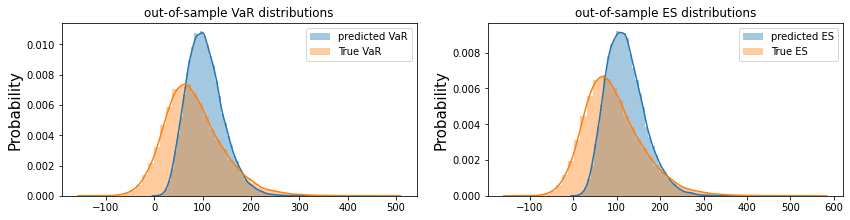

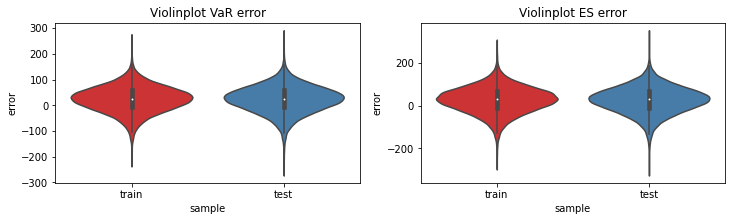

In [20]:
p1 = time.time()

var_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)

train_var_RUbased(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 100, lr = 0.1)

print('\n VaR Computation: ', time.time() - p1)#132
p1 = time.time()

q_pred = var_NN(X_train).data
q_pred_test = var_NN(X_test).data
train_es_RUbased(q_pred, es_NN, X_train_es = X_train, y_train = Y_train, eps = eps,
               epochs = 300,verbose = None)

print('\n ES Computation: ', time.time() - p1)

plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)

### 1 hidden layer of 100 units networks without randomized layers

In [0]:
data_simulator(dim_X=50, eps = 0.025)

===Train VaR process===
[iter 0] err = 864.66
[iter 100] err = 116.527
[iter 200] err = 109.682
[iter 300] err = 103.115
[iter 400] err = 97.915
[iter 500] err = 93.973
NRMSE in-sample VaR:  tensor(0.9622)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(0.9889)
NRMSE out-sample ES:  tensor(0.)
CPU times: user 2.76 s, sys: 834 ms, total: 3.6 s
Wall time: 3.29 s


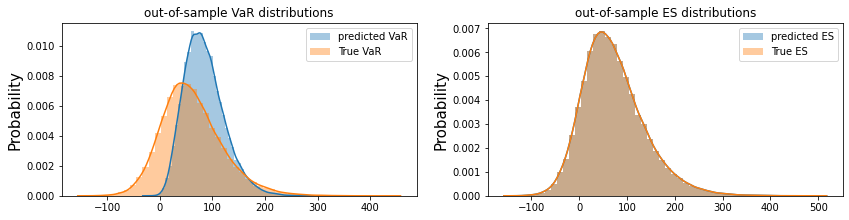

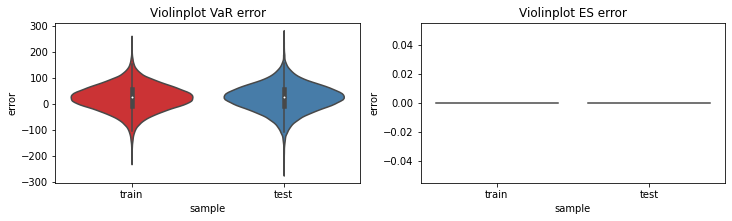

In [22]:
%%time

var_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)

train_var_RUbased(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 100, lr = 0.1)

plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

### Train median

===Train VaR process===
[iter 0] err = 20.749
[iter 100] err = 11.994
[iter 200] err = 11.471
[iter 300] err = 11.381
[iter 400] err = 11.348
[iter 500] err = 11.294
NRMSE in-sample VaR:  tensor(0.3305)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(0.3622)
NRMSE out-sample ES:  tensor(0.)
CPU times: user 6.58 s, sys: 973 ms, total: 7.55 s
Wall time: 7.01 s


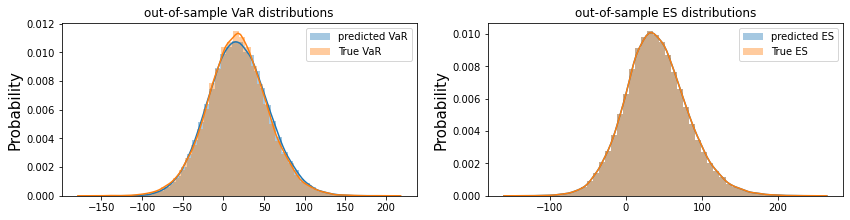

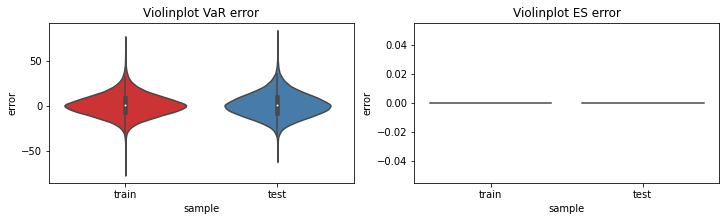

In [23]:
%%time
data_simulator(dim_X = 50, eps = 0.5)

var_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)
es_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)

train_var_RUbased(var_NN, X_train_var= X_train, y_train= Y_train, eps = eps,
                epochs = 500, stop_eps = 1e-8, verbose = 100, lr = 0.1)

plot_function(var_NN(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

### Train mean

NRMSE in-sample VaR:  tensor(0.9795)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(0.9827)
NRMSE out-sample ES:  tensor(0.)
CPU times: user 1.36 s, sys: 404 ms, total: 1.76 s
Wall time: 1.18 s


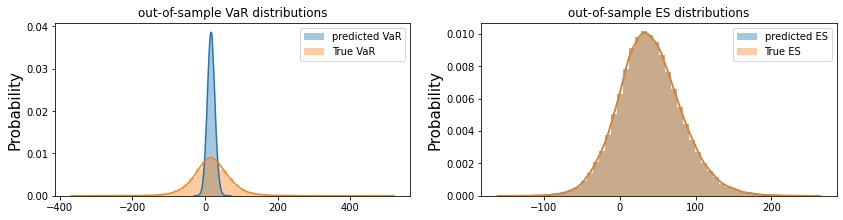

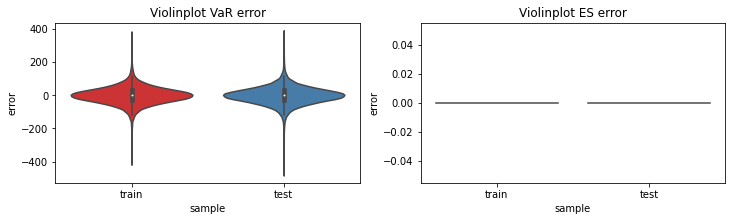

In [24]:
%%time

RP_100layers_relu = Randomprojection(Layers=[dim_X,100], random_state= None, activation= 'relu')

LRsolution_readout = LR_readout()
LRsolution_readout.fit(RP_100layers_relu.fit_transform(X_train), Y_train)

plot_function(LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_train)), Y_train,
              true_ES_train, true_ES_train,
              LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_test)), Y_test,
              true_ES_test, true_ES_test)

NRMSE in-sample VaR:  tensor(0.3305)
NRMSE in-sample ES:  tensor(1.3868)
NRMSE out-sample VaR:  tensor(0.3622)
NRMSE out-sample ES:  tensor(1.3901)


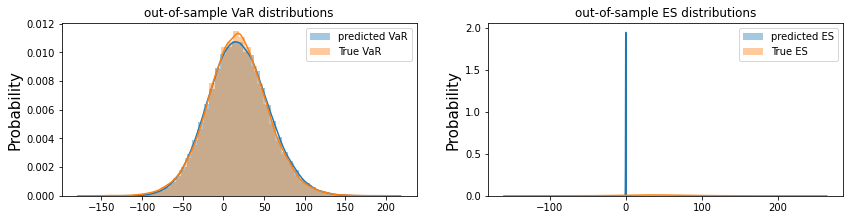

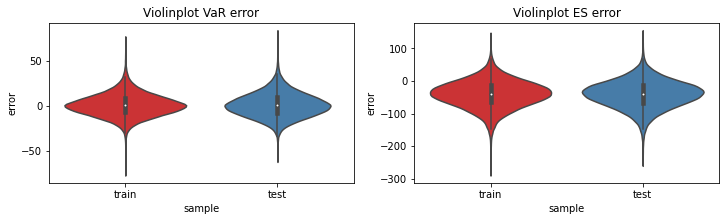

In [25]:
plot_function(var_NN(X_train), true_VaR_train,
              es_NN(X_train), true_ES_train,
              var_NN(X_test), true_VaR_test,
              es_NN(X_test), true_ES_test)

### 2 quantiles output


===Train VaR process===
[iter 0] err = 116.374
[iter 100] err = 81.946
[iter 200] err = 80.209
[iter 300] err = 80.058
[iter 400] err = 79.818
[iter 500] err = 79.833
NRMSE in-sample VaR:  tensor(0.3507)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(0.3825)
NRMSE out-sample ES:  tensor(0.)
CPU times: user 3.21 s, sys: 1.05 s, total: 4.26 s
Wall time: 3.96 s


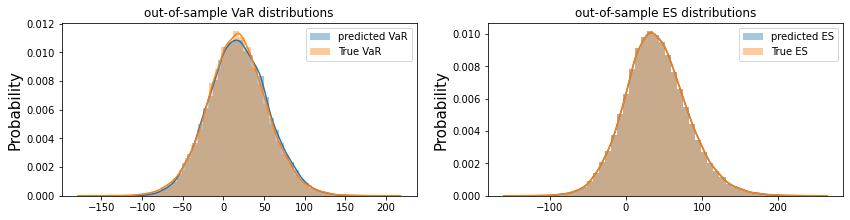

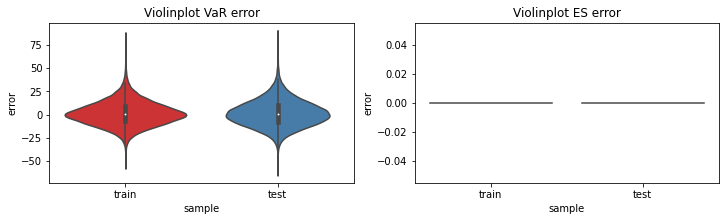

In [26]:
%%time

var_NN = NN_nlayers(Layers=[dim_X,100,2], activation = 'relu').to(device)

train_var_RUbased_2q(var_NN, X_train_var= X_train, y_train= Y_train, eps_list=[eps,0.5],
                epochs = 500, stop_eps = 1e-8, verbose = 100)

q_pred = var_NN(X_train)[:,0:1].data
q_pred_test = var_NN(X_test)[:,0:1].data

plot_function(q_pred, true_VaR_train,
              true_ES_train, true_ES_train,
              q_pred_test, true_VaR_test,
              true_ES_test, true_ES_test)

### 2 quantiles ouput v2

===Train VaR process===
[iter 0] err = 58.256
[iter 100] err = 41.016
[iter 200] err = 40.368
[iter 300] err = 40.039
[iter 400] err = 39.934
[iter 500] err = 39.89
NRMSE in-sample VaR:  tensor(0.3497)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(0.3832)
NRMSE out-sample ES:  tensor(0.)
CPU times: user 3.91 s, sys: 1.44 s, total: 5.35 s
Wall time: 5.07 s


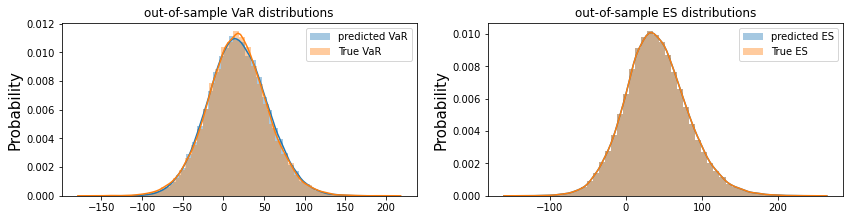

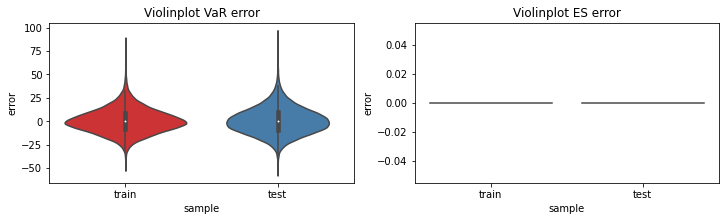

In [27]:
%%time

var_NN = NN_nlayers(Layers=[dim_X,100,2], activation = 'relu').to(device)

train_var_RUbased_2q_v2(var_NN, X_train_var= X_train, y_train= Y_train, eps_list=[eps,0.5],
                epochs = 500, stop_eps = 1e-8, verbose = 100)

q_pred = var_NN(X_train)[:,0:1].data
q_pred_test = var_NN(X_test)[:,0:1].data

plot_function(q_pred, true_VaR_train,
              true_ES_train, true_ES_train,
              q_pred_test, true_VaR_test,
              true_ES_test, true_ES_test)

## 5.2 Linear program for quantile regression

Considering a quantile regression problem that we want to minimize the quantile loss:

$$\mathbb{E}\left[\ell(y,q)\right] =  \mathbb{E}\left[(y-q)^{+} - \epsilon(y-q)\right]$$

Approximated by 
\begin{align} 
\mathcal{L(q)} =& \frac{1}{n}\sum \left\{[y^{(i)}-q(X^{(i)})]^+ - \epsilon[y^{i} - q(X^{(i)})] \right\}\\
=&\frac{1}{n}\sum \left\{ (1-\epsilon)[y^{(i)}-q(X^{(i)})]^+ + \epsilon[y^{i} - q(X^{(i)})]^- \right\}
\end{align}

This loss (in the first line) can be divided by $\epsilon$ and then last term $y^i$ can be removed at the training step. This case leads to the trained loss in 5.1.

Now we try to rewrite the loss $\mathcal{L}$ to linear form (using the second line) as below:

$$ \mathcal{L}(q) = \frac{1}{n}\left[(1-\epsilon)1_n^Tu^+ + \epsilon1_n^Tu^- \right]$$

With $u = y-q$. Supposing, in addition, that $q(X)$ is a linear function of $X$: $q(X) =  \betaX$. The minimization problem can be reformulated as a linear programming problem:

\begin{align} 
\min_{z}& \hspace{0.5cm} c^Tz  \\
\mbox{subject to}:& \hspace{0.5cm} Az = b \\
 & \hspace{0.5cm} z \geq [-\infty 1_p \hspace{0.2cm} 0_{n} \hspace{0.2cm} 0_{n}]^T
\end{align}

Where
$$
c=\left[\begin{array}{c}
0_p \\
\frac{(1-\epsilon)}{n}1_n \\
\frac{(\epsilon)}{n}1_n
\end{array}\right] \quad z=\left[\begin{array}{c}
\beta \\
u^+ \\
u^-
\end{array}\right] \quad b = y
$$

$$A=\left[X_{n \times p} \hspace{0.2cm}  1_{n\times n} \hspace{0.2cm} \text{-}1_{n\times n}\right]\,  _{ n \times (p+2n)}$$

In [0]:
class linear_quantreg:

    def __init__(self, eps = 0.025) :
        self.eps = eps

    def min_positive(self,vector):
        check = vector[vector>0]
        if check.nelement() == 0:
            return torch.tensor(np.inf).to(device)
        else:
            return check.min()
            
    def fit(self, X, y, tol = 1e-6, maxiter = 1000, verbose = 50):
        tau = 1 - self.eps
        n, p = X.shape

        e = torch.ones(n, 1).to(device)
        c = -y
        b = (1-tau)*matmul(X.T,e)
        A = X.T

        solver = LR_readout(intercept = False)
        solver.fit(A.T,c)
        y = solver.coef.to(device)
        resid = c - matmul(A.T,y)
        x = e*(1-tau)
        s = e-x
        z = torch.max(resid, torch.tensor(0.).to(device)) +tol
        w = torch.max(-resid, torch.tensor(0.).to(device))+tol

        best_gap = torch.tensor([np.inf]).to(device)
        i = 0
        gap = (matmul(x.T,z) + matmul(s.T,w))[-1]
        while (gap > tol) and (i<= maxiter):
            # Compute predictor direction
            Q_1 = 1./(z/x+w/s)
            r1_tilde = c - matmul(A.T,y)
            r2_tilde = b - matmul(A,x)
            inv_A_Q_1_AT = torch.inverse(matmul(A*Q_1.T, A.T))
            dy = matmul(inv_A_Q_1_AT, r2_tilde + matmul(A*Q_1.T, r1_tilde))
            dx = (matmul(A.T,dy) - r1_tilde)*Q_1
            ds = -dx
            dz = -z*(e + dx/x)
            dw = -w*(e + ds/s)
            # Compute primal and dual steps
            alpha_p = torch.min(torch.min(self.min_positive(-x/dx),
                                          self.min_positive(-s/ds))*0.9995,
                                torch.tensor(1.).to(device))
            alpha_d = torch.min(torch.min(self.min_positive(-z/dz),
                                          self.min_positive(-w/dw))*0.9995,
                                torch.tensor(1.).to(device))
            if min(alpha_p, alpha_d) <1 :
                # Update mu
                mu = (matmul(x.T,z) + matmul(s.T,w))[-1]
                mu_new = (matmul((x + alpha_p*dx).T, z + alpha_d*dz) + matmul((s + alpha_p*ds).T, w + alpha_d*dw))[-1]
                mu = (mu_new**3/mu**2)/(2.*n)
                
                # Compute corrector direction
                r1_hat = mu*(1/s - 1/x) + 1/x*dx*dz - 1/s*ds*dw
                delta_y = matmul(inv_A_Q_1_AT, matmul(A*Q_1.T, r1_hat))
                delta_x = (matmul(A.T,delta_y) - r1_hat)*Q_1
                delta_s = -delta_x
                delta_z = -z -(delta_x*z + mu - dx*dz)/x
                delta_w = -w -(delta_s*w + mu - ds*dw)/s
                # Compute primal and dual steps

                alpha_p = torch.min(torch.min(self.min_positive(-x/delta_x),
                                              self.min_positive(-s/delta_s))*0.9995,
                                    torch.tensor(1.).to(device))
                alpha_d = torch.min(torch.min(self.min_positive(-z/delta_z),
                                              self.min_positive(-w/delta_w))*0.9995,
                                    torch.tensor(1.).to(device))
                # Update parameters
                y += alpha_d*delta_y
                z += alpha_d*delta_z
                w += alpha_d*delta_w
                x += alpha_p*delta_x
                s += alpha_p*delta_s
            else:
                y += alpha_d*dy
                z += alpha_d*dz
                w += alpha_d*dw
                x += alpha_p*dx
                s += alpha_p*ds
            gap = (matmul(x.T,z) + matmul(s.T,w))[-1]
            if best_gap > gap:
                best_gap = gap
                params = y,z,w,x,s
            if verbose != None:
                if i % verbose ==0:
                    print(f'iter{i} | gap = {gap} | alpha_p = {alpha_p} | alpha_d = {alpha_d}')        
            i +=1
        self.y, self.z, self.w, self.x, self.s = params
    
    def predict(self,X):
        return matmul(X,self.y)


In [29]:
%%time
rq = linear_quantreg()
rq.fit(X_train, Y_train, maxiter=2000, verbose = None)

CPU times: user 16.3 s, sys: 7.92 s, total: 24.3 s
Wall time: 24.1 s


NRMSE in-sample VaR:  tensor(1.1552)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(1.1535)
NRMSE out-sample ES:  tensor(0.)


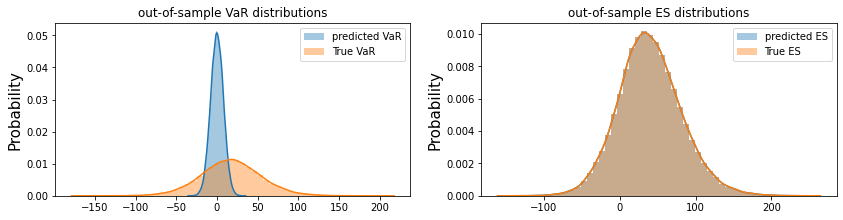

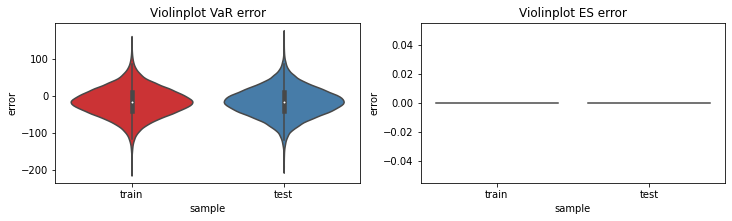

In [30]:
plot_function(rq.predict(X_train), true_VaR_train,
              true_ES_train, true_ES_train,
              rq.predict(X_test), true_VaR_test,
              true_ES_test, true_ES_test)

## 5.3 Something new

In [0]:
data_simulator()

In [0]:
class NN_multi_tasks(nn.Module):

    def __init__(self, Layers = [50, 100,1], activation = 'relu'):
        super(NN_multi_tasks, self).__init__()
        self.shared_fc = nn.Linear(Layers[0], Layers[1])
        self.fc0_task1 = nn.Linear(Layers[1],Layers[1])
        self.fc1_task1 = nn.Linear(Layers[1], Layers[2])
        self.fc0_task2 = nn.Linear(Layers[1],Layers[1])
        self.fc1_task2 = nn.Linear(Layers[1], Layers[2])
        self.fc0_task3 = nn.Linear(Layers[1],Layers[1])
        self.fc1_task3 = nn.Linear(Layers[1]+2, Layers[2])
      
        if activation.capitalize() == 'Sigmoid' :
            self.activation = torch.sigmoid
        elif activation.capitalize() == 'Relu':
            self.activation = F.relu
        elif activation.capitalize() == 'Tanh':
            self.activation = F.tanh
        elif activation.capitalize() == 'Log_softmax':
            self.activation = F.log_softmax
        elif activation.capitalize() == 'Leakyrelu':
            self.activation = F.leaky_relu

    def forward(self, x):
        x = x.to(device)
        shared_out = self.activation(self.shared_fc(x))
        out1 = self.activation(self.fc0_task1(shared_out))
        out1 = self.fc1_task1(out1)

        #out2 = self.activation(self.fc0_task2(shared_out))
        #out2 = self.fc1_task2(out2)
        out2 = self.fc1_task2(shared_out)

        out3 = self.activation(self.fc0_task3(shared_out))
        out3 = self.fc1_task3(torch.cat([out1.data.clone(), out2.data.clone(), out3], dim = 1))
       
        return out1, out2, out3

In [0]:
def train_var_multi_tasks(model_var, X_train_var, y_train, eps = eps,
                    epochs=300, stop_eps = 1e-8, verbose = None, lr=0.1) :
    optimizer_var = torch.optim.Adam(model_var.parameters(), lr=lr)
    zero_vector = torch.zeros_like(y_train)
    i = 0
    err, best_err, err1 = np.inf, np.inf, np.inf
    if verbose != None:
        print('===Train VaR process===')
    while (err > stop_eps) and (i <= epochs):
        q1, m, q2 = model_var(X_train_var)
        loss_q1 = torch.mean(1/(0.5)*torch.max(y_train - q1, zero_vector) + q1)
        loss_m = torch.nn.functional.mse_loss(m, y_train)
        loss_q2 = torch.mean(1/eps*torch.max(y_train - q2, zero_vector) + q2)
        #loss = loss_1 + loss_2
        
        model_var.zero_grad()
        loss_q1.backward(retain_graph=True)

        model_var.zero_grad()
        loss_m.backward(retain_graph=True)
        
        model_var.zero_grad()
        loss_q2.backward()
        optimizer_var.step()
        
        err = loss_q2.data.item()
        if err < best_err:
            best_err = err
            torch.save(model_var.state_dict(), 'best')    
        if verbose != None : 
            if i % verbose == 0:
                print('[iter {}] |err1 = {} | err2 = {}'.format(i, round(err1, 3), round(err,3)))
        i += 1
  
    model_var.load_state_dict(torch.load('best'))
    model_var.eval()

===Train VaR process===
[iter 0] |err1 = inf | err2 = 1080.446
[iter 50] |err1 = inf | err2 = 126.425
[iter 100] |err1 = inf | err2 = 104.051
[iter 150] |err1 = inf | err2 = 95.359
[iter 200] |err1 = inf | err2 = 95.425
[iter 250] |err1 = inf | err2 = 101.591
[iter 300] |err1 = inf | err2 = 99.514
[iter 350] |err1 = inf | err2 = 89.247
[iter 400] |err1 = inf | err2 = 95.0
[iter 450] |err1 = inf | err2 = 82.636
[iter 500] |err1 = inf | err2 = 80.497
NRMSE in-sample VaR:  tensor(0.8027)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(0.8476)
NRMSE out-sample ES:  tensor(0.)
CPU times: user 8.2 s, sys: 3.26 s, total: 11.5 s
Wall time: 11.3 s


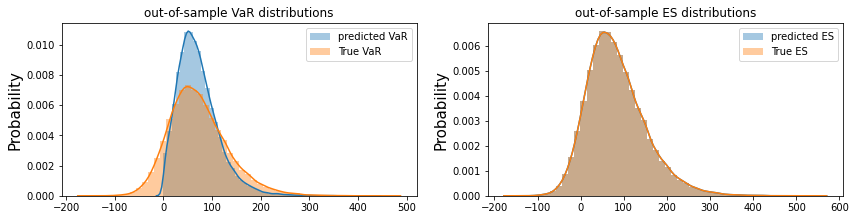

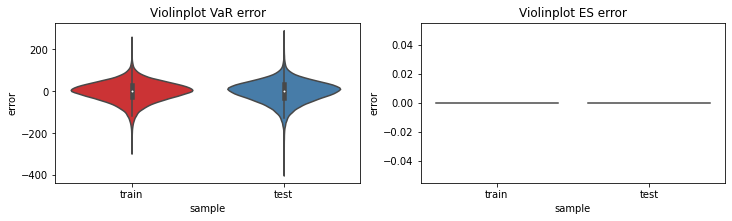

In [34]:
%%time
var_new_NN = NN_multi_tasks(Layers=[dim_X,100,1], activation = 'relu').to(device)

train_var_multi_tasks(var_new_NN, X_train_var=X_train, y_train=Y_train, epochs = 500,
                        verbose = 50, lr = 0.1)

_,_,q_pred = var_new_NN(X_train)
_,_,q_pred_test = var_new_NN(X_test)

plot_function(q_pred.data, true_VaR_train,
              true_ES_train, true_ES_train,
              q_pred_test.data, true_VaR_test,
              true_ES_test, true_ES_test)

===Train VaR process===
[iter 0] err = 20.704
[iter 100] err = 13.156
[iter 200] err = 12.902
[iter 300] err = 12.883
[iter 400] err = 12.821
[iter 500] err = 12.839
===Train VaR process===
[iter 0] err = 1045.801
[iter 100] err = 108.884
[iter 200] err = 99.592
[iter 300] err = 92.906
[iter 400] err = 97.928
[iter 500] err = 89.025
NRMSE in-sample VaR:  tensor(0.8282)
NRMSE in-sample ES:  tensor(0.)
NRMSE out-sample VaR:  tensor(0.8626)
NRMSE out-sample ES:  tensor(0.)
CPU times: user 4.66 s, sys: 1.42 s, total: 6.07 s
Wall time: 5.56 s


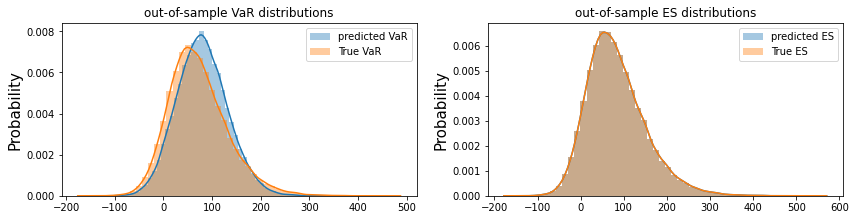

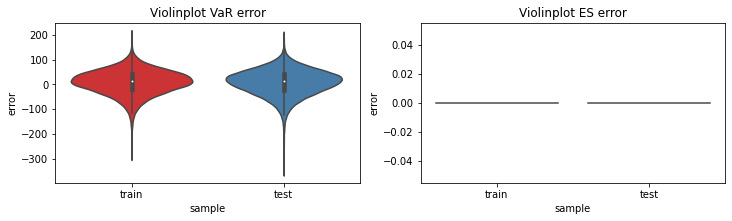

In [35]:
%%time
median_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)
RP_100layers_relu = Randomprojection(Layers=[dim_X,100], random_state= None, activation= 'relu')
LRsolution_readout = LR_readout()
LRsolution_readout.fit(RP_100layers_relu.fit_transform(X_train), Y_train)
var_NN = NN_nlayers(Layers=[dim_X+2,100,1], activation = 'relu').to(device)

mean_train = LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_train))
mean_test = LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_test))

train_var_RUbased(median_NN, X_train_var= X_train, y_train= Y_train, eps = 0.5,
                epochs = 500, stop_eps = 1e-8, verbose = 100, lr = 0.1)
train_var_RUbased(var_NN, X_train_var= torch.cat([X_train, median_NN(X_train).data, mean_train], dim = 1), y_train= Y_train, eps = 0.025,
                epochs = 500, stop_eps = 1e-8, verbose = 100)

plot_function(var_NN(torch.cat([X_train, median_NN(X_train), mean_train], dim = 1)), true_VaR_train,
              true_ES_train, true_ES_train,
              var_NN(torch.cat([X_test, median_NN(X_test), mean_test], dim = 1)), true_VaR_test,
              true_ES_test, true_ES_test)

# 6.Benchmark

In [0]:
def run(turn = 0, dim_X = 50):
    
    ### 1 layer-100
    var_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)

    train_var_RUbased(var_NN, X_train_var= X_train, y_train= Y_train, 
                    epochs = 500, stop_eps = 1e-8, verbose = None)

    q_pred = var_NN(X_train).data
    q_pred_test = var_NN(X_test).data
    
    NRMSEvar_train_1NN = NRMSE(q_pred, true_VaR_train.data)
    NRMSEvar_test_1NN = NRMSE(q_pred_test, true_VaR_test.data)

    del var_NN 
    torch.cuda.empty_cache()  

    ### 2 layers-100
    var_NN = NN_nlayers(Layers=[dim_X,100,100,1], activation = 'relu').to(device)

    train_var_RUbased(var_NN, X_train_var= X_train, y_train= Y_train, 
                    epochs = 500, stop_eps = 1e-8, verbose = None)

    q_pred = var_NN(X_train).data
    q_pred_test = var_NN(X_test).data
  
    NRMSEvar_train_2NN = NRMSE(q_pred, true_VaR_train.data)
    NRMSEvar_test_2NN = NRMSE(q_pred_test, true_VaR_test.data)

    del var_NN 
    torch.cuda.empty_cache()  

    ### 2 quantiles
    var_NN = NN_nlayers(Layers=[dim_X,100,2], activation = 'relu').to(device)

    train_var_RUbased_2q(var_NN, X_train_var= X_train, y_train= Y_train, 
                    epochs = 500, stop_eps = 1e-8, verbose = None, eps_list = [eps,0.5])

    q_pred = var_NN(X_train)[:,0:1].data
    q_pred_test = var_NN(X_test)[:,0:1].data
    
    NRMSEvar_train_2q = NRMSE(q_pred, true_VaR_train.data)
    NRMSEvar_test_2q = NRMSE(q_pred_test, true_VaR_test.data)

    del var_NN 
    torch.cuda.empty_cache()  

    ### mean, median, Q97.5% NN
    mean_med_Q975_NN = NN_multi_tasks(Layers=[dim_X,100,1], activation = 'relu').to(device)
    train_var_multi_tasks(mean_med_Q975_NN, X_train_var=X_train, y_train=Y_train, epochs = 500,
                            verbose = None, lr = 0.1)
    
    _,_,q_pred = mean_med_Q975_NN(X_train)
    _,_,q_pred_test = mean_med_Q975_NN(X_test)

    NRMSEvar_train_mean_med_Q975 = NRMSE(q_pred, true_VaR_train.data)
    NRMSEvar_test_mean_med_Q975 = NRMSE(q_pred_test, true_VaR_test.data)

    del mean_med_Q975_NN 
    torch.cuda.empty_cache()  

    ### mean, med, Q97.5% 
    median_NN = NN_nlayers(Layers=[dim_X,100,1], activation = 'relu').to(device)
    RP_100layers_relu = Randomprojection(Layers=[dim_X,100], random_state= None, activation= 'relu')
    LRsolution_readout = LR_readout()
    LRsolution_readout.fit(RP_100layers_relu.fit_transform(X_train), Y_train)
    var_NN = NN_nlayers(Layers=[dim_X+2,100,1], activation = 'relu').to(device)

    mean_train = LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_train))
    mean_test = LRsolution_readout.predict(RP_100layers_relu.fit_transform(X_test))

    train_var_RUbased(median_NN, X_train_var= X_train, y_train= Y_train, eps = 0.5,
                    epochs = 500, stop_eps = 1e-8, verbose = None, lr = 0.1)
    train_var_RUbased(var_NN, X_train_var= torch.cat([X_train, median_NN(X_train).data, mean_train], dim = 1), y_train= Y_train, eps = 0.025,
                    epochs = 500, stop_eps = 1e-8, verbose = None)
    NRMSEvar_train_MMQ = NRMSE(var_NN(torch.cat([X_train, median_NN(X_train), mean_train], dim = 1)),
                               true_VaR_train)
    NRMSEvar_test_MMQ = NRMSE(var_NN(torch.cat([X_test, median_NN(X_test), mean_test], dim = 1)),
                              true_VaR_test)
    
    del median_NN,  var_NN
    torch.cuda.empty_cache() 
    
    return [
            [NRMSEvar_train_1NN, NRMSEvar_train_2NN, NRMSEvar_train_2q, 
             NRMSEvar_train_mean_med_Q975, NRMSEvar_train_MMQ],
            [NRMSEvar_test_1NN, NRMSEvar_test_2NN, NRMSEvar_test_2q, 
             NRMSEvar_test_mean_med_Q975, NRMSEvar_test_MMQ]
            ]

In [77]:
resultat_dimX_50 = []

for i in tqdm(range(10)):
    data_simulator(dim_X = 50)
    resultat_dimX_50.append(run(i, dim_X = 50))
    del X_train, Y_train, X_test, Y_test, true_VaR_train, true_VaR_test, true_ES_train, true_ES_test
    torch.cuda.empty_cache()
    gc.collect()

Text(0.5, 1.0, 'VaR')

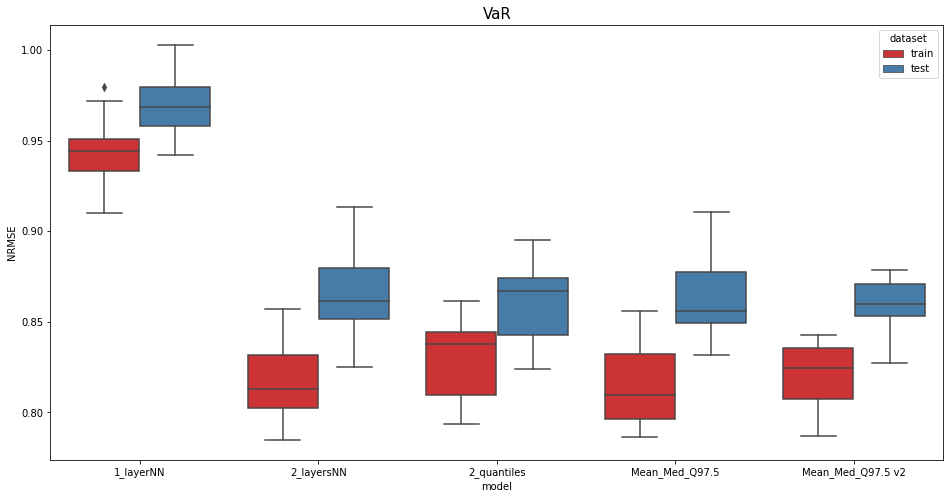

In [78]:
resultat_dimX_50 = pd.DataFrame(resultat_dimX_50)
var_res = list(chain.from_iterable(resultat_dimX_50.iloc[:,0].tolist())) + list(chain.from_iterable(resultat_dimX_50.iloc[:,1].tolist()))
var_res = pd.DataFrame(var_res, columns = ['NRMSE'])
var_res['model'] = ['1_layerNN', '2_layersNN', '2_quantiles', 'Mean_Med_Q97.5', 'Mean_Med_Q97.5 v2']*20
var_res['dataset'] = ['train']*50 +['test']*50
var_res['NRMSE'] = var_res['NRMSE'].apply(lambda x: float(x))
plt.figure(figsize=(16,8))
sns.boxplot(x="model", y="NRMSE", hue="dataset", data=var_res, palette="Set1",showfliers = True)
plt.title("VaR", fontsize=15)    


In [37]:
resultat_dimX_10 = []

for i in tqdm(range(20)):
    data_simulator(dim_X = 10)
    resultat_dimX_10.append(run(i, dim_X = 10))
    del X_train, Y_train, X_test, Y_test, true_VaR_train, true_VaR_test, true_ES_train, true_ES_test
    torch.cuda.empty_cache()
    gc.collect()

Text(0.5, 1.0, 'VaR')

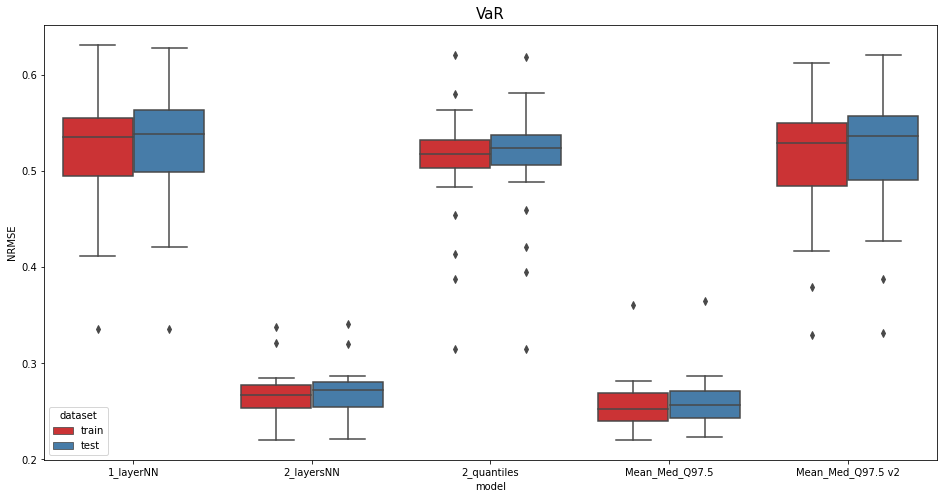

In [38]:
resultat_dimX_10 = pd.DataFrame(resultat_dimX_10)
var_res = list(chain.from_iterable(resultat_dimX_10.iloc[:,0].tolist())) + list(chain.from_iterable(resultat_dimX_10.iloc[:,1].tolist()))
var_res = pd.DataFrame(var_res, columns = ['NRMSE'])
var_res['model'] = ['1_layerNN', '2_layersNN', '2_quantiles', 'Mean_Med_Q97.5', 'Mean_Med_Q97.5 v2']*40
var_res['dataset'] = ['train']*100 +['test']*100
var_res['NRMSE'] = var_res['NRMSE'].apply(lambda x: float(x))
plt.figure(figsize=(16,8))
sns.boxplot(x="model", y="NRMSE", hue="dataset", data=var_res, palette="Set1",showfliers = True)
plt.title("VaR", fontsize=15)  